<a href="https://colab.research.google.com/github/k1sihyeon/tensorflow/blob/main/modulus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

bash: cannot set terminal process group (872): Inappropriate ioctl for device
bash: no job control in this shell



/content# ^C


In [22]:
!pip install nvidia-modulus nvidia-modulus-sym
!pip install nvidia-modulus[all]
!pip install quadpy orthopy ndim gdown

!git clone https://github.com/NVIDIA/modulus.git
!git clone https://github.com/openhackathons-org/End-to-End-AI-for-Science.git

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [23]:
!ls -lrt
!pwd
!cp -rf /content/End-to-End-AI-for-Science/workspace/python ./example

total 12
drwxr-xr-x  1 root root 4096 Jan 31 14:23 sample_data
drwxr-xr-x  4 root root 4096 Feb  2 02:14 End-to-End-AI-for-Science
drwxr-xr-x 10 root root 4096 Feb  2 02:34 modulus
/content


# 1D diffusion

 - 열 전도율이 다른 2개의 철사 사이의 열전도율 시뮬레이션

In [24]:
import torch
import numpy as np
from sympy import Symbol, Eq, Function, Number

import modulus
from modulus.sym.hydra import instantiate_arch , ModulusConfig
from modulus.sym.solver import Solver
from modulus.sym.domain import Domain
from modulus.sym.geometry.primitives_1d import Line1D
from modulus.sym.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseInteriorConstraint,
)
from modulus.sym.domain.validator import PointwiseValidator
from modulus.sym.domain.monitor import PointwiseMonitor
from modulus.sym.key import Key
from modulus.sym.node import Node
from modulus.sym.eq.pde import PDE

## Step 1: Creating the geometry

In [25]:
L1 = Line1D(0, 1)
L2 = Line1D(1, 2)

D1 = 1e1
D2 = 1e-1

Tc = 100
Ta = 0
Tb = (Tc + (D1 / D2) * Ta) / (1 + (D1 / D2))

print(Ta)
print(Tb)
print(Tc)

0
0.9900990099009901
100


## Step 2: Defining the PDEs and creating the nodes

In [26]:
class Diffusion(PDE):
    name = "Diffusion"

    def __init__(self, T="T", D="D", Q=0, dim=3, time=True):
        # set params
        self.T = T
        self.dim = dim
        self.time = time

        # coordinates
        x, y, z = Symbol("x"), Symbol("y"), Symbol("z")

        # time
        t = Symbol("t")

        # make input variables
        input_variables = {"x": x, "y": y, "z": z, "t": t}
        if self.dim == 1:
            input_variables.pop("y")
            input_variables.pop("z")
        elif self.dim == 2:
            input_variables.pop("z")
        if not self.time:
            input_variables.pop("t")

        # Temperature
        assert type(T) == str, "T needs to be string"
        T = Function(T)(*input_variables)

        # Diffusivity
        if type(D) is str:
            D = Function(D)(*input_variables)
        elif type(D) in [float, int]:
            D = Number(D)

        # Source
        if type(Q) is str:
            Q = Function(Q)(*input_variables)
        elif type(Q) in [float, int]:
            Q = Number(Q)

        # set equations
        self.equations = {}
        self.equations["diffusion_" + self.T] = (
            T.diff(t)
            - (D * T.diff(x)).diff(x)
            - (D * T.diff(y)).diff(y)
            - (D * T.diff(z)).diff(z)
            - Q
        )


In [27]:
class DiffusionInterface(PDE):
    name = "DiffusionInterface"

    def __init__(self, T_1, T_2, D_1, D_2, dim=3, time=True):
        # set params
        self.T_1 = T_1
        self.T_2 = T_2
        self.dim = dim
        self.time = time

        # coordinates
        x, y, z = Symbol("x"), Symbol("y"), Symbol("z")
        normal_x, normal_y, normal_z = (
            Symbol("normal_x"),
            Symbol("normal_y"),
            Symbol("normal_z"),
        )

        # time
        t = Symbol("t")

        # make input variables
        input_variables = {"x": x, "y": y, "z": z, "t": t}
        if self.dim == 1:
            input_variables.pop("y")
            input_variables.pop("z")
        elif self.dim == 2:
            input_variables.pop("z")
        if not self.time:
            input_variables.pop("t")

        # Diffusivity
        if type(D_1) is str:
            D_1 = Function(D_1)(*input_variables)
        elif type(D_1) in [float, int]:
            D_1 = Number(D_1)
        if type(D_2) is str:
            D_2 = Function(D_2)(*input_variables)
        elif type(D_2) in [float, int]:
            D_2 = Number(D_2)

        # variables to match the boundary conditions (example Temperature)
        T_1 = Function(T_1)(*input_variables)
        T_2 = Function(T_2)(*input_variables)

        # set equations
        self.equations = {}
        self.equations["diffusion_interface_dirichlet_" + self.T_1 + "_" + self.T_2] = (
            T_1 - T_2
        )
        flux_1 = D_1 * (
            normal_x * T_1.diff(x) + normal_y * T_1.diff(y) + normal_z * T_1.diff(z)
        )
        flux_2 = D_2 * (
            normal_x * T_2.diff(x) + normal_y * T_2.diff(y) + normal_z * T_2.diff(z)
        )
        self.equations["diffusion_interface_neumann_" + self.T_1 + "_" + self.T_2] = (
            flux_1 - flux_2
        )

### Creating Neural Network nodes

In [28]:
@modulus.sym.main(config_path="conf", config_name="config")
def run(cfg: ModulusConfig) -> None:

    # make list of nodes to unroll graph on
    diff_u1 = Diffusion(T="u_1", D=D1, dim=1, time=False)
    diff_u2 = Diffusion(T="u_2", D=D2, dim=1, time=False)
    diff_in = DiffusionInterface("u_1", "u_2", D1, D2, dim=1, time=False)

    diff_net_u_1 = instantiate_arch(
        input_keys=[Key("x")],
        output_keys=[Key("u_1")],
        cfg=cfg.arch.fully_connected,
    )
    diff_net_u_2 = instantiate_arch(
        input_keys=[Key("x")],
        output_keys=[Key("u_2")],
        cfg=cfg.arch.fully_connected,
    )

    nodes = (
        diff_u1.make_nodes()
        + diff_u2.make_nodes()
        + diff_in.make_nodes()
        + [diff_net_u_1.make_node(name="u1_network", jit=cfg.jit)]
        + [diff_net_u_2.make_node(name="u2_network", jit=cfg.jit)]
    )

        # sympy variables
    x = Symbol("x")

    # right hand side (x = 2) Pt c
    rhs = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=L2,
        outvar={"u_2": Tc},
        batch_size=cfg.batch_size.rhs,
        criteria=Eq(x, 2),
    )
    domain.add_constraint(rhs, "right_hand_side")

    # left hand side (x = 0) Pt a
    lhs = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=L1,
        outvar={"u_1": Ta},
        batch_size=cfg.batch_size.lhs,
        criteria=Eq(x, 0),
    )
    domain.add_constraint(lhs, "left_hand_side")

    # interface 1-2
    interface = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=L1,
        outvar={
            "diffusion_interface_dirichlet_u_1_u_2": 0,
            "diffusion_interface_neumann_u_1_u_2": 0,
        },
        batch_size=cfg.batch_size.interface,
        criteria=Eq(x, 1),
    )
    domain.add_constraint(interface, "interface")

    # interior 1
    interior_u1 = PointwiseInteriorConstraint(
        nodes=nodes,
        geometry=L1,
        outvar={"diffusion_u_1": 0},
        bounds={x: (0, 1)},
        batch_size=cfg.batch_size.interior_u1,
    )
    domain.add_constraint(interior_u1, "interior_u1")

    # interior 2
    interior_u2 = PointwiseInteriorConstraint(
        nodes=nodes,
        geometry=L2,
        outvar={"diffusion_u_2": 0},
        bounds={x: (1, 2)},
        batch_size=cfg.batch_size.interior_u2,
    )
    domain.add_constraint(interior_u2, "interior_u2")

# validation data
    x = np.expand_dims(np.linspace(0, 1, 100), axis=-1)
    u_1 = x * Tb + (1 - x) * Ta
    invar_numpy = {"x": x}
    outvar_numpy = {"u_1": u_1}
    val = PointwiseValidator(nodes=nodes,invar=invar_numpy, true_outvar=outvar_numpy)
    domain.add_validator(val, name="Val1")

    # make validation data line 2
    x = np.expand_dims(np.linspace(1, 2, 100), axis=-1)
    u_2 = (x - 1) * Tc + (2 - x) * Tb
    invar_numpy = {"x": x}
    outvar_numpy = {"u_2": u_2}
    val = PointwiseValidator(nodes=nodes, invar=invar_numpy, true_outvar=outvar_numpy)
    domain.add_validator(val, name="Val2")

In [29]:
domain = Domain()

## Step 3: Setting up the domain and assigning the boundary and PDE constraints

In [30]:
!python /content/example/source_code/diffusion_1d/diffusion_bar.py

2024-02-02 02:40:26.116493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 02:40:26.116553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 02:40:26.118309: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 02:40:29.652761: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
0
0.9900990099009901
100
/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_t

In [31]:
!python /content/example/source_code/diffusion_1d/diffusion_bar.py

2024-02-02 02:44:48.290711: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 02:44:48.290766: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 02:44:48.300026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 02:44:51.647758: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
0
0.9900990099009901
100
/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_t

## Step 4: Adding Validators, Inferencers and Monitors

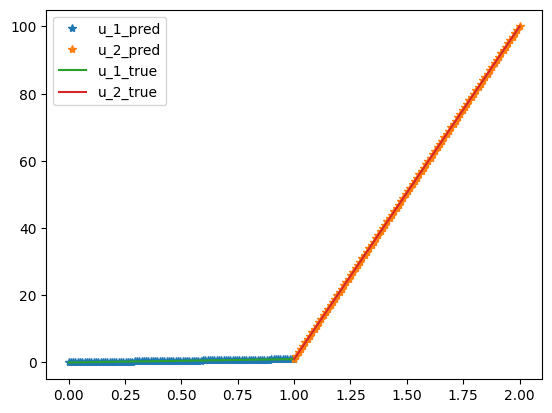

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()

network_dir = "./outputs/diffusion_bar/validators/"
data_1 = np.load(network_dir + "Val1.npz", allow_pickle=True)
data_2 = np.load(network_dir + "Val2.npz", allow_pickle=True)
data_1 = np.atleast_1d(data_1.f.arr_0)[0]
data_2 = np.atleast_1d(data_2.f.arr_0)[0]

plt.plot(data_1["x"][:, 0], data_1["pred_u_1"][:, 0], "*", label="u_1_pred")
plt.plot(data_2["x"][:, 0], data_2["pred_u_2"][:, 0], "*", label="u_2_pred")
plt.plot(data_1["x"][:, 0], data_1["true_u_1"][:, 0], label="u_1_true")
plt.plot(data_2["x"][:, 0], data_2["true_u_2"][:, 0], label="u_2_true")

plt.legend()
plt.show()

In [33]:
!python /content/example/source_code/diffusion_1d/diffusion_bar_parameterized.py

2024-02-02 02:45:53.190817: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 02:45:53.190880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 02:45:53.192558: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 02:45:57.000585: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
0
100/(10.0*D1 + 1)
100
/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to

<Figure size 640x480 with 0 Axes>

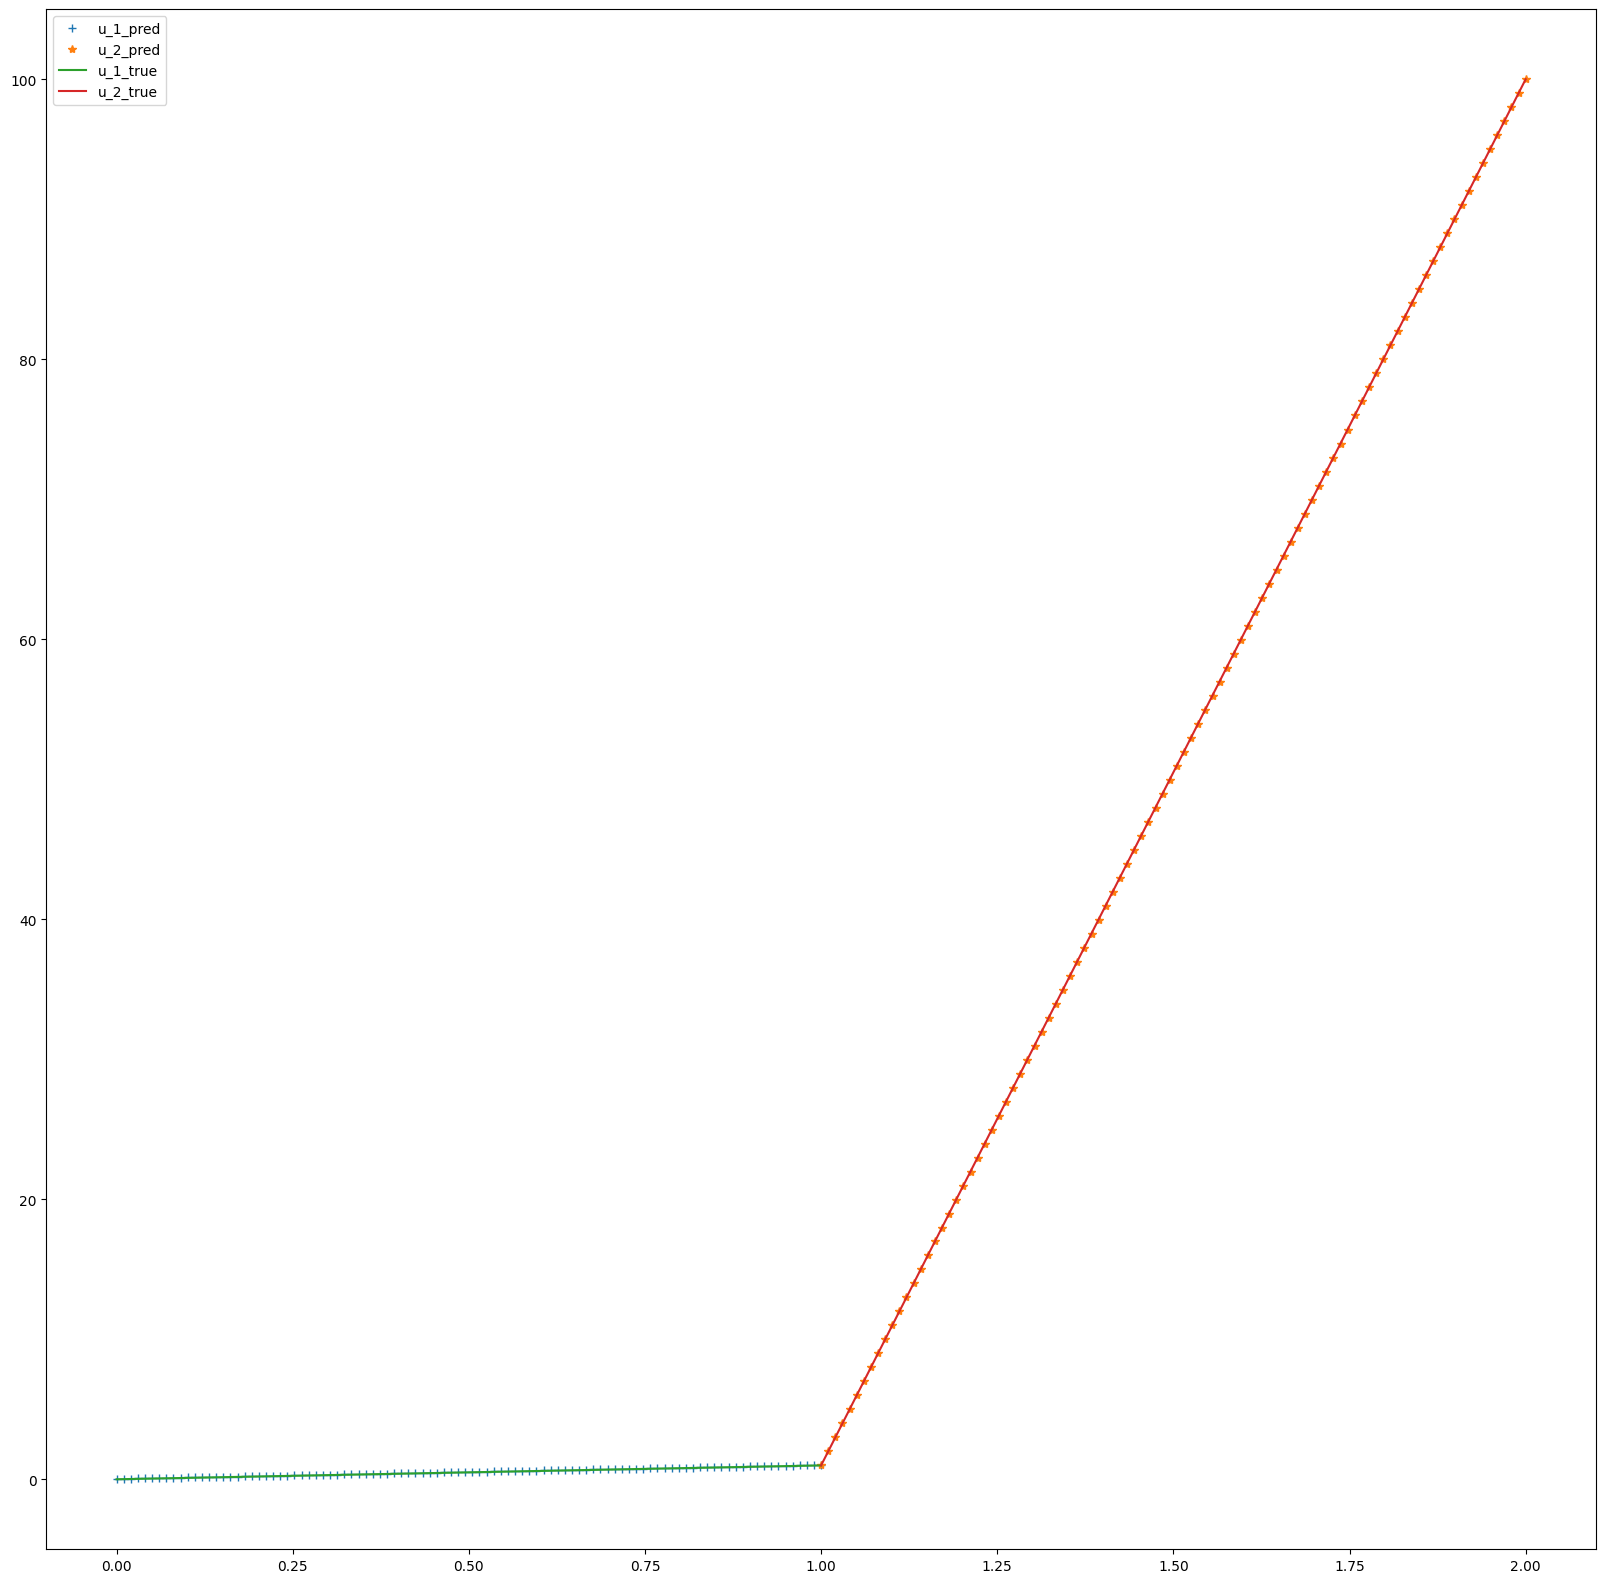

In [34]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()

network_dir = "./outputs/diffusion_bar_parameterized/validators/"
data_1 = np.load(network_dir + "Val1.npz", allow_pickle=True)
data_2 = np.load(network_dir + "Val2.npz", allow_pickle=True)
data_1 = np.atleast_1d(data_1.f.arr_0)[0]
data_2 = np.atleast_1d(data_2.f.arr_0)[0]
plt.figure( figsize=(20,20))
plt.plot(data_1["x"][:, 0], data_1["pred_u_1"][:, 0], "+", label="u_1_pred")
plt.plot(data_2["x"][:, 0], data_2["pred_u_2"][:, 0], "*", label="u_2_pred")
plt.plot(data_1["x"][:, 0], data_1["true_u_1"][:, 0], label="u_1_true")
plt.plot(data_2["x"][:, 0], data_2["true_u_2"][:, 0], label="u_2_true")

plt.legend()
plt.show()

---

In [35]:
import os
import gdown

url = 'https://drive.google.com/uc?id=1IXEGbM3NOO6Dig1sxG1stHubwb09-D2N&export=download'
output = '/content/example/source_code/navier_stokes/dataset.zip'
#output = str(os.path.realpath(os.path.dirname(__file__)))+ '/navier_stokes/dataset.zip'
gdown.cached_download(url, output, quiet=False,proxy=None,postprocess=gdown.extractall)
#os.remove(output)

Cached Downloading: /content/example/source_code/navier_stokes/dataset.zip
Downloading...
From: https://drive.google.com/uc?id=1IXEGbM3NOO6Dig1sxG1stHubwb09-D2N&export=download
To: /root/.cache/gdown/tmp1h_8zt_7/dl
100%|██████████| 17.1M/17.1M [00:00<00:00, 55.2MB/s]


'/content/example/source_code/navier_stokes/dataset.zip'

In [ ]:
!python /content/example/source_code/navier_stokes/navier_stokes.py

2024-02-02 03:01:23.499189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-02 03:01:23.499264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-02 03:01:23.500915: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-02 03:01:25.767738: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/usr/local/lib/python3.10/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_to_1.2/changes_to_job_work